In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Case 1 Relativistic Magnetic Field Numerical Tracking Exercise
This suite of notebooks takes takes a relativistic particle initially moving with some $\textbf{v}$, then see how it behaves in three different cases:

- Case 1 : $\textbf{B} = B_0 \hat{z}$ and $\textbf{E} = 0$
- Case 2 : $\textbf{B} = B_0 \sin(t) \hat{z}$ and $\textbf{E} = E_0 \cos(t)\hat{z}$
- Case 3 : $\textbf{B} = B_0 \sin(t) \hat{z}$ and $\textbf{E} = E_0 \cos(t)\hat{x}$

### Analytical Solution
Solving the same Lorentz force equation of motion relativistically yields the modified form
$$
\frac{\text{d}\textbf{p}}{\text{d}t} = q (\textbf{v} \times \textbf{B}) \Longrightarrow \gamma m \dot{\textbf{v}} = q (\textbf{v} \times \textbf{B}) \Longrightarrow \dot{\textbf{v}} = \frac{q}{\gamma m} (\textbf{v} \times \textbf{B}),
$$
where $\gamma$ is the Lorentz factor,
$$
\gamma = \frac{1}{\sqrt{1-v^2/c^2}}.
$$
While I *can* assume for these cases that $\textbf{B}$ is going in the $z$ direction, I will keep it general here.

In [94]:
### Constants
c  = 3E8           # speed of light     (m/s)
q  = 1.602E-19     # charge of particle (Coulombs)
m  = 9.109E-31     # mass of particle   (kg)
dt = 0.05          # timestep, Notice that larger timesteps are more error bound.
sim_len = 50       # Simulation Length

### Simulation Parameters
N = int(sim_len/dt)     # number of points
t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

In [63]:
# defining the lorentz factor
gamma = lambda v: 1 / np.sqrt(1 - v**2/c**2)

# define relativistic kinetic energy
ke_rel = lambda v: (gamma(v) - 1) * m * c**2

### Explicit (Forward) Euler

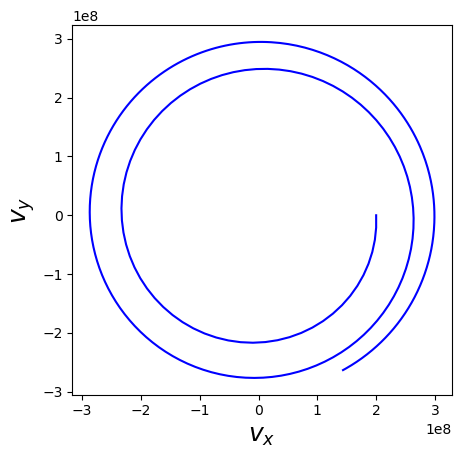

In [99]:
### Initialize Tracked Variables
B = np.zeros((N+1,3))    # Magnetic Field
r = np.zeros((N+1,3))    # Particle Position
v = np.zeros((N+1,3))    # Particle Velocity

### Initial Conditions
B[0] = [0,0,8E-13]       # Strength of B Field [B0_x, B0_y, B0_z]
r[0] = [0,0,0]           # [r0_x, r0_y, r0_z]
v[0] = [2E8,0,0]       # [v0_x, v0_y, v0_z]

### Functional Forms of Fields
bfld = lambda t: B[0]    # Will be constant this time

### Perform the Explicit Euler Algorithm
for i in range(N):
    # Check if particle is going too fast
    if (np.linalg.norm(v[i], axis=0) >= c):
        print(f"too fast, offending velocity {v[i]}, offending velocity mag {np.linalg.norm(v[i],axis=0):0.2e}")
        break

    # Update B Field for current timestep
    B[i] = bfld(i * dt)

    # Update the velocity according to the Lorentz force equation
    v[i+1] = v[i] + q * np.linalg.cross(v[i], B[i]) / (gamma(np.linalg.norm(v[i], axis=0)) * m)

    # Update the position according to the velocity
    r[i+1] = r[i] + v[i+1] * dt

### plot the velocities
plt.plot(v[:,0], v[:,1], 'b-',label='Relativistic Velocity')
plt.xlabel('$v_x$',fontsize = 18)
plt.ylabel('$v_y$',fontsize = 18)
plt.gca().set_aspect("equal")
plt.show()

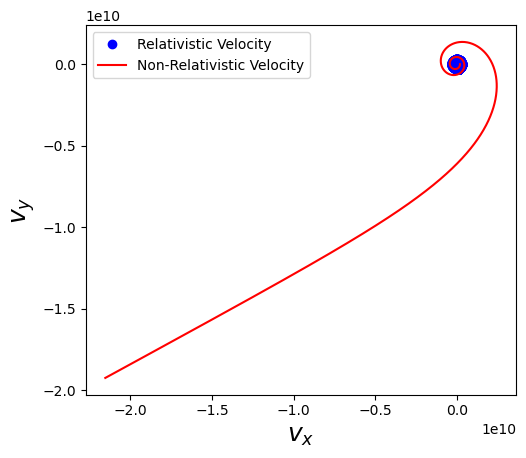

In [97]:
nonrel_v = np.zeros((N+1, 3))
nonrel_r = np.zeros((N+1, 3))
nonrel_v[0] = v[0]
nonrel_r[0] = r[0]

### Perform the Non-Relativistic Explicit Euler Algorithm
for i in range(N):
    # Update the velocity according to the Lorentz force equation
    nonrel_v[i+1] = nonrel_v[i] + q * np.linalg.cross(v[i], B[i]) / m

    # Update the position according to the velocity
    nonrel_r[i+1] = nonrel_r[i] + nonrel_v[i+1] * dt

# Compare the relativistic velocities with the non-relativistic velocities
plt.plot(v[:,0], v[:,1], 'bo',label='Relativistic Velocity')
plt.plot(nonrel_v[:,0], nonrel_v[:,1], 'r-',label='Non-Relativistic Velocity')
plt.xlabel('$v_x$',fontsize = 18)
plt.ylabel('$v_y$',fontsize = 18)
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

Though, I think a more enlightening comparison would be between the kinetic energies. So,

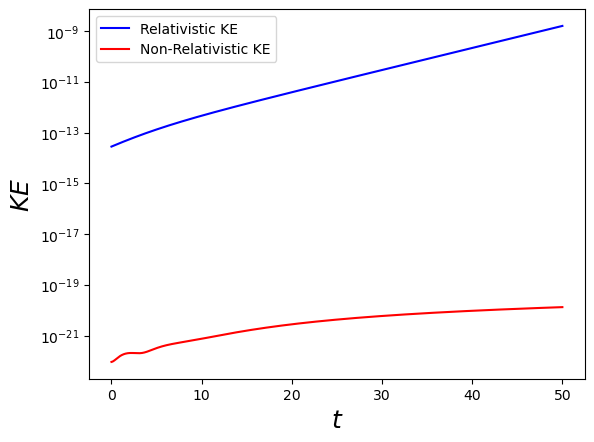

In [100]:
# Create a kinetic energy array both classically and relativistically
ke = ke_rel(np.linalg.norm(v,axis=1))
nonrel_ke = 0.5 * m * np.linalg.norm(nonrel_v,axis=1)

# Compare the arrays against time
plt.semilogy(t, ke, 'b-',label='Relativistic KE')
plt.semilogy(t, nonrel_ke, 'r-',label='Non-Relativistic KE')
plt.xlabel('$t$',fontsize = 18)
plt.ylabel('$KE$',fontsize = 18)
plt.legend()
plt.show()

If I plotted it regularly, then the increase in the non-relativistic KE would be difficult to see. This aligns with what the KE should be, so I'm reasonably confident in how I implemented it here. Note that I also had to cherry pick a magnetic field strength here- if I set it too high, then the velocity would spiral above $c$.

### Implicit (Backward) Euler
The diff. eq I am solving takes a bit more of a complicated form- as I am doing the more general case of $B$ in all three directions. From the Lorentz force:
$$
\dot{\begin{bmatrix}
v_x\\
v_y\\
v_z
\end{bmatrix}}
= \frac{q}{\gamma m}
\begin{bmatrix}
v_x\\
v_y\\
v_z
\end{bmatrix} \times
\begin{bmatrix}
B_x\\
B_y\\
B_z
\end{bmatrix} =\frac{q}{\gamma m} \begin{bmatrix}
0 & B_z & -B_y \\
-B_z & 0 & B_x \\
B_y & -B_x & 0
\end{bmatrix} \begin{bmatrix}
v_x \\
v_y \\
v_z
\end{bmatrix}
$$
This takes the form of a 2nd rank antisymmetric tensor- as apparently cross products are better expressed that way. Now, there is also a hidden $v$ in the $\gamma$, which makes getting this ready for the Implicit Euler Algorithm a bit more of a chore.

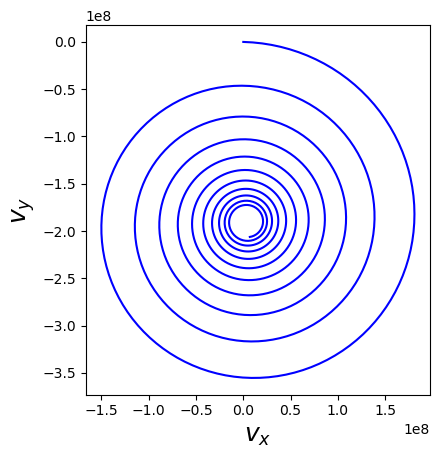

In [101]:
### Initialize Tracked Variables
B = np.zeros((N+1,3))    # Magnetic Field
r = np.zeros((N+1,3))    # Particle Position
v = np.zeros((N+1,3))    # Particle Velocity

### Initial Conditions
B[0] = [0,0,8E-12]       # Strength of B Field [B0_x, B0_y, B0_z]
r[0] = [0,0,0]           # [r0_x, r0_y, r0_z]
v[0] = [2E8,0,0]         # [v0_x, v0_y, v0_z]

### Functional Forms of Fields
bfld = lambda t: B[0]    # Will be constant this time

### Perform the Relativistic Implicit (Backward) Euler Algorithm
for i in range(N):
    # Check if particle is going too fast
    if (np.linalg.norm(v[i], axis=0) >= c):
        print(f"too fast, offending velocity {v[i]}, offending velocity mag {np.linalg.norm(v[i],axis=0):0.2e}")
        break

    # Update B Field for current timestep
    B[i] = bfld(i * dt)

    ### Build matrices for equation
    A = np.array([
         [  0.0   ,  B[i][2], -B[i][1]],
         [-B[i][2],    0.0  ,  B[i][0]],
         [ B[i][1], -B[i][0],    0.0]
    ])

    # scale it properly
    A = q / (m * gamma(np.linalg.norm(v[i]))) * A
    M = np.linalg.inv(np.identity(3) - A * dt)

    # this handles the x-y motion, which is affected by the b field for this case
    v[i+1] = np.linalg.matmul(M,v[i])

    # Update the position according to the velocity
    r[i+1] = r[i] + v[i+1] * dt

### plot the positions
plt.plot(r[:,0], r[:,1], 'b-',label='Relativistic Positions')
plt.xlabel('$v_x$',fontsize = 18)
plt.ylabel('$v_y$',fontsize = 18)
plt.gca().set_aspect("equal")
plt.show()

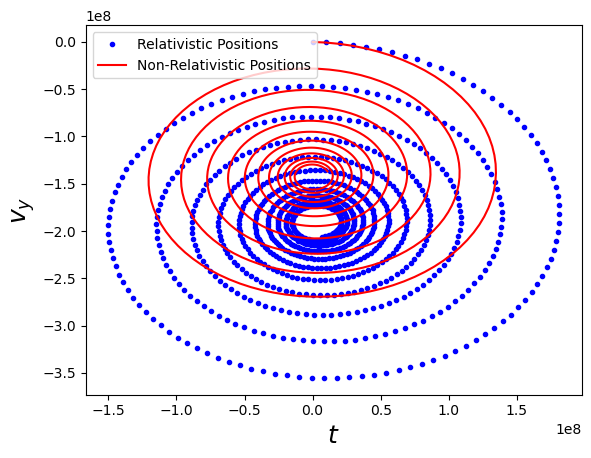

In [102]:
nonrel_v = np.zeros((N+1, 3))
nonrel_r = np.zeros((N+1, 3))
nonrel_v[0] = v[0]
nonrel_r[0] = r[0]

### Perform the Non-Relativistic Implicit (Backward) Euler Algorithm
for i in range(N):
    # Update B Field for current timestep
    B[i] = bfld(i * dt)

    # Build matrix for equation
    A = np.array([
         [  0.0   ,  B[i][2], -B[i][1]],
         [-B[i][2],    0.0  ,  B[i][0]],
         [ B[i][1], -B[i][0],    0.0]
    ])

    # scale it right
    A = q/m * A

    M = np.linalg.inv(np.identity(3) - A * dt)

    # this handles the x-y motion, which is affected by the b field for this case
    nonrel_v[i+1] = np.linalg.matmul(M, nonrel_v[i])

    # Update the position according to the velocity
    nonrel_r[i+1] = nonrel_r[i] + nonrel_v[i+1] * dt


# Compare the relativistic positions with the non-relativistic positions
plt.plot(r[:,0], r[:,1], 'b.',label='Relativistic Positions')
plt.plot(nonrel_r[:,0], nonrel_r[:,1], 'r-',label='Non-Relativistic Positions')
plt.xlabel('$t$',fontsize = 18)
plt.ylabel('$v_y$',fontsize = 18)
plt.legend()
plt.show()

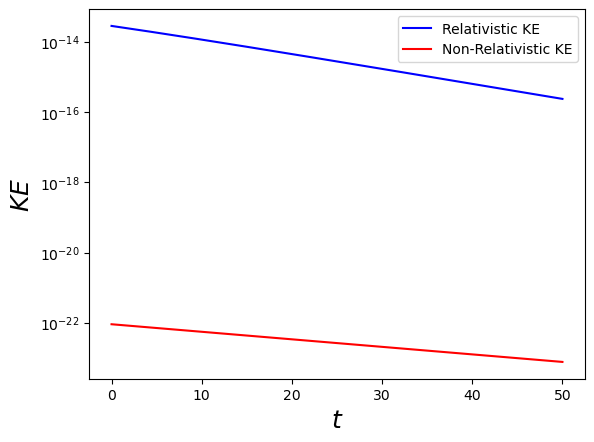

In [103]:
# Create a kinetic energy array both classically and relativistically
ke = ke_rel(np.linalg.norm(v,axis=1))
nonrel_ke = 0.5 * m * np.linalg.norm(nonrel_v,axis=1)

# Compare the arrays against time
plt.semilogy(t, ke, 'b-',label='Relativistic KE')
plt.semilogy(t, nonrel_ke, 'r-',label='Non-Relativistic KE')
plt.xlabel('$t$',fontsize = 18)
plt.ylabel('$KE$',fontsize = 18)
plt.legend()
plt.show()

Unsure about this one- I don't like how the relativistic velocity and the regular velocity are slowing down at the same rate. I am certain I implemented $\gamma$ wrong- will do later

### Runge-Kutta (RK4)
From what I can understand, the RK4 is defined by
$$
\textbf{v}^{n+1} = \textbf{v}^n + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right)\text{dt}
$$
where
$$
k_1 = A \textbf{v}^n
$$
$$
k_2 = A \left(\textbf{v}^n +  \frac{k_1}{2}\, \text{dt}\right)
$$
$$
k_3 = A \left(\textbf{v}^n + \frac{k_2}{2}\,\text{dt}\right)
$$
$$
k_3 = A \left(\textbf{v}^n + k_3\,\text{dt}\right)
$$

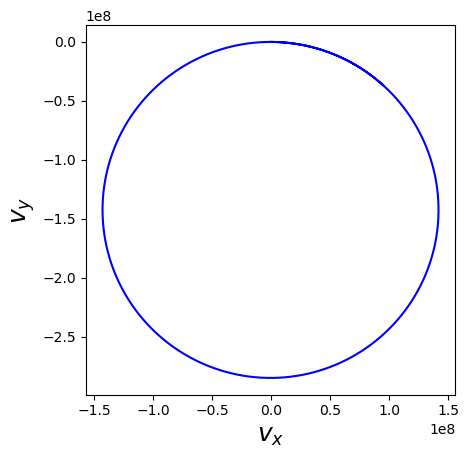

In [105]:
### Initialize Tracked Variables
B = np.zeros((N+1,3))    # Magnetic Field
r = np.zeros((N+1,3))    # Particle Position
v = np.zeros((N+1,3))    # Particle Velocity

### Initial Conditions
B[0] = [0,0,8E-13]       # Strength of B Field [B0_x, B0_y, B0_z]
r[0] = [0,0,0]           # [r0_x, r0_y, r0_z]
v[0] = [2E7,0,0]         # [v0_x, v0_y, v0_z]

### Functional Forms of Fields
bfld = lambda t: B[0]    # Will be constant this time


for i in range(N):
    # Check if particle is going too fast
    if (np.linalg.norm(v[i], axis=0) >= c):
        print(f"too fast, offending velocity {v[i]}, offending velocity mag {np.linalg.norm(v[i],axis=0):0.2e}")
        break

    # Update B Field for current timestep
    B[i] = bfld(i * dt)

    ### Build matrices for equation
    A = np.array([
         [  0.0   ,  B[i][2], -B[i][1]],
         [-B[i][2],    0.0  ,  B[i][0]],
         [ B[i][1], -B[i][0],    0.0]
    ])

    # scale it properly
    A = q * A / (gamma(np.linalg.norm(v[i])) * m)

    ## compute the four k values
    k_1 = np.matmul(A, v[i])
    # this adds the timestep to both indices of the vector
    # wanted to clarify as vector + scalar is not well defined
    k_2 = np.matmul(A, v[i] + k_1 * dt/2)
    k_3 = np.matmul(A, v[i] + k_2 * dt/2)
    k_4 = np.matmul(A, v[i] + k_3 * dt)

    ## get the next value
    v[i+1] = v[i] + (k_1 + 2*k_2 + 2*k_3 + k_4) * dt/6

    # Update the position according to the velocity
    r[i+1] = r[i] + v[i+1] * dt

### plot the velocities
plt.plot(r[:,0], r[:,1], 'b-',label='Relativistic Velocities')
plt.xlabel('$v_x$',fontsize = 18)
plt.ylabel('$v_y$',fontsize = 18)
plt.gca().set_aspect("equal")
plt.show()

This does seem to conserve energy properly, so I am a bit more confident in how I implemented this. Though, if I have a timestep that is too large over long time frames, it spirals inward like the implicit Euler.